## Confusion Matrix

Mean IoU: 0.4942
Class-wise IoU:
	 0: 0.8639
	 1: 0.1654
	 2: 0.1058
	 3: 0.5200
	 4: 0.2937
	 5: 0.6307
	 6: 0.8797


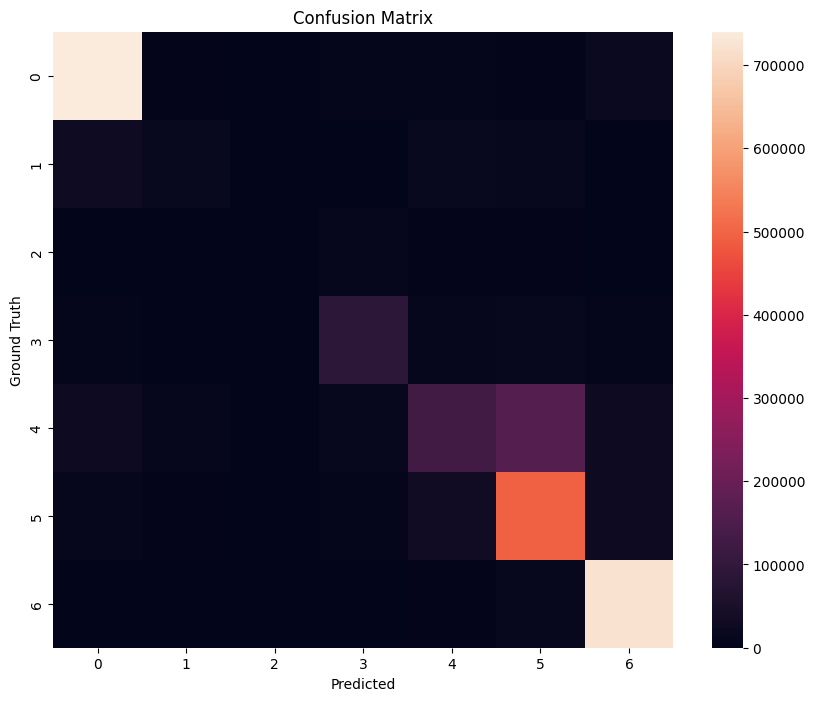

In [4]:
from dataset import SegmentationDatasetLite
from segnet_model import SegNet
import torch
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

NUM_CLASSES = 7

def compute_iou(conf_matrix, labels):
    ious = {}
    for cls in labels:
        tp = conf_matrix[cls, cls]
        fp = conf_matrix[:, cls].sum() - tp
        fn = conf_matrix[cls, :].sum() - tp
        denom = tp + fp + fn
        if denom == 0:
            ious[cls] = np.nan
        else:
            ious[cls] = tp / denom
    return ious

def evaluate_model(model, dataloader, device):
    model.eval()
    num_classes = NUM_CLASSES
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # [B, H, W]

            for pred, gt in zip(preds, labels):
                mask = gt != 255
                pred = pred[mask]
                gt = gt[mask]

                pred_np = pred.cpu().numpy().flatten()
                gt_np = gt.cpu().numpy().flatten()

                # Update confusion matrix
                conf_matrix += confusion_matrix(gt_np, pred_np, labels=list(range(num_classes)))

    ious = compute_iou(conf_matrix, list(range(num_classes)))
    miou = np.nanmean(list(ious.values()))
    return ious, miou, conf_matrix

data_dir = '../data/idd20k_lite_prepared'
model_path = '../trained_models/segnet_lite_ep28_20250512_164009.pth'
batch_size = 24
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = 7

data_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

test_dataset = SegmentationDatasetLite(data_dir=data_dir, transform=data_transforms, mode='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = SegNet(in_channels=3, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device)) 

ious, miou, conf_matrix = evaluate_model(model, test_loader, device)

print(f"Mean IoU: {miou:2.4f}")
print("Class-wise IoU:")
for k, v in ious.items():
    print(f"\t{k:2d}: {v:2.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='rocket', xticklabels=list(range(NUM_CLASSES)), yticklabels=list(range(NUM_CLASSES)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.show()

## Overlayed masks

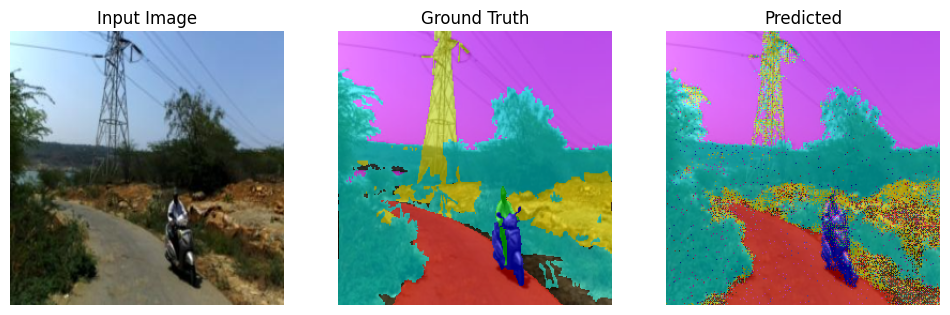

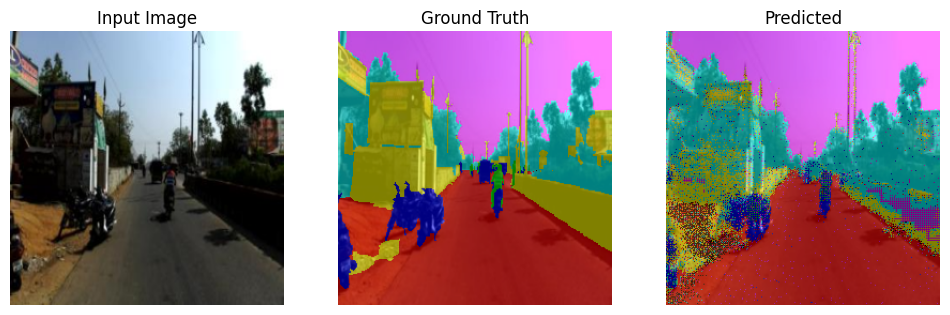

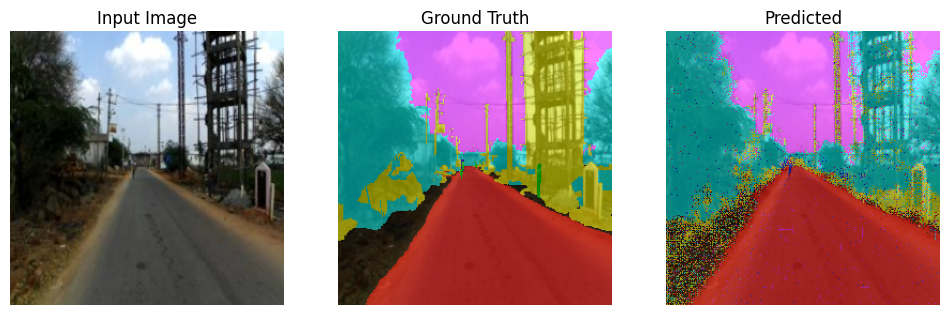

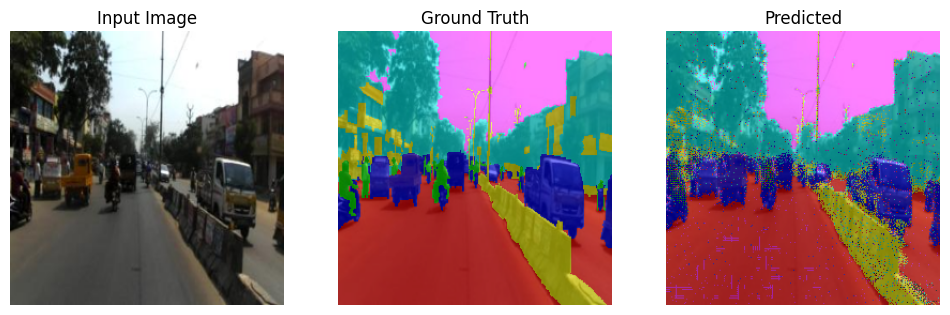

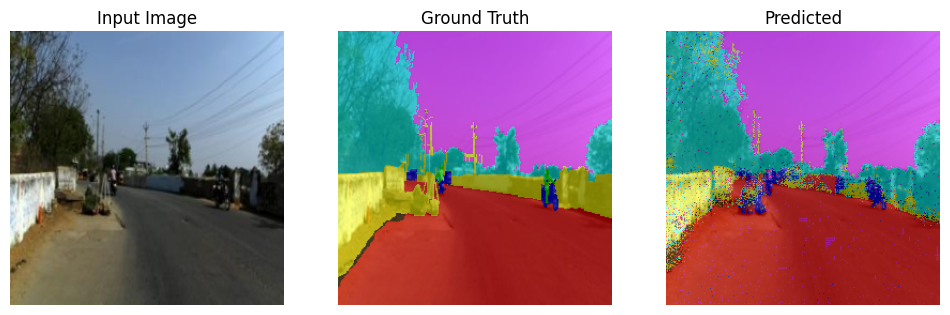

In [3]:
from dataset import SegmentationDatasetLite
from segnet_model import SegNet
import torch
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

NUM_CLASSES = 7

# Overlay Ground Truth on Image
def overlay_mask(image, mask, alpha=0.5):
    # Define a color map for the labels
    color_map = {
        255: [0, 0, 0],     # Class 255 (ignore label)
        0: [255, 0, 0],     # Class 0
        2: [0, 255, 0],     # Class 2
        3: [0, 0, 255],     # Class 3
        4: [255, 255, 0],   # Class 4
        5: [0, 255, 255],   # Class 5
        6: [255, 0, 255],   # Class 6
    }
    
    # Create a blank RGB image for the label
    label_color = np.zeros_like(image)

    # Map each unique label to its corresponding color
    for label_value, color in color_map.items():
        label_color[mask == label_value] = color

    # Overlay the label on the image
    overlay = cv2.addWeighted(image, 1 - alpha, label_color, alpha, 0)
    return overlay

def visualize_predictions(model, n_imgs, device):
    
    data_transforms = transforms.Compose([
        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
    ])
    
    test_dataset = SegmentationDatasetLite(data_dir=data_dir, transform=data_transforms, mode='test')
    model.eval()
    
    for i in range(n_imgs):
        img, label = test_dataset[i]
        img_in = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img_in)
            pred = torch.argmax(pred, dim=1).squeeze(0)

        pred = pred.cpu().numpy()
        img = img.permute(1, 2, 0).numpy()
        img = (img * 255).astype(np.uint8)
        label_overlap = overlay_mask(img, label)
        pred_overlap = overlay_mask(img, pred)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(label_overlap)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_overlap)
        plt.title('Predicted')
        plt.axis('off')

        plt.show()

data_dir = '../data/idd20k_lite_prepared'
model_path = '../trained_models/segnet_lite_ep28_20250512_164009.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SegNet(in_channels=3, num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

visualize_predictions(model, 5, device)